In [ ]:
import os
import numpy as np
from typing import Union
import cv2
import matplotlib.pyplot as plt
import glob as glob
import json
import pandas as pd
from PIL import Image
import keras

Using TensorFlow backend.


In [ ]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, SeparableConv2D,Concatenate,Conv2DTranspose, Add, UpSampling2D, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, MaxPool2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img


from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical 

from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.regularizers import l2
# from sklearn.utils import class_weight


from google.colab import drive
drive.mount('/content/drive')

os.chdir('drive/MyDrive/xray_lung')
os.getcwd()

In [ ]:
image_path = 'Montgomery/CXR_png'
mask_path = 'Montgomery/Masks'

In [ ]:
img_size = (512,512)
classes = ['lung']
num_classes = len(classes)
batch_size = 4

In [ ]:
#Use weighted loss
import tensorflow.keras as K
import tensorflow as tf
def weighted_categorical_crossentropy(weights = class_weight):
    # weights = [0.9,0.05,0.04,0.01]
    def wcce(y_true, y_pred):
        Kweights = K.initializers.constant(weights)
        if not tf.is_tensor(y_pred): y_pred =  K.initializers.constant(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return K.losses.categorical_crossentropy(y_true, y_pred) * K.backend.sum(y_true * Kweights, axis=-1)
    return wcce

In [ ]:
#Creating dice loss and metrics
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
#Load data and label
train_images = np.load(f'{segment_data_path}/train_images.npy').astype('float32')
train_masks = np.load(f'{segment_data_path}/train_masks.npy').astype('float32')
valid_images = np.load(f'{segment_data_path}/valid_images.npy').astype('float32')
valid_masks = np.load(f'{segment_data_path}/valid_masks.npy').astype('float32')
# valid_masks = np.expand_dims(valid_masks, axis = -1)
# train_masks = np.expand_dims(train_masks, axis = -1)
print(train_images.shape)
print(train_masks.shape)
print(valid_images.shape)
print(valid_masks.shape)

(110, 512, 512, 3)
(110, 512, 512)
(28, 512, 512, 3)
(28, 512, 512)


In [ ]:
#Calculate class weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
           'balanced',
            np.unique(np.ravel(train_masks).tolist()), 
            np.ravel(train_masks).tolist())
# class_weights = {k:v for k,v in zip([0,1], class_weights)}
class_weights

array([0.67212478, 1.9524347 ])

In [ ]:
#One hot encoding
valid_masks = to_categorical(valid_masks, num_classes = 2)
train_masks = to_categorical(train_masks, num_classes = 2)

In [ ]:
#Porting model
from image_segmentation.keras_segmentation.models.unet import unet_mini

model = unet_mini(n_classes=2,  input_height=img_size[0], input_width=img_size[1]  )

model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 512, 512, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 512, 512, 32) 0           conv2d_77[0][0]                  
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 512, 512, 32) 9248        dropout_35[0][0]                 
______________________________________________________________________________________

In [ ]:
#Set up, compile and train
# callback = EarlyStopping(monitor='val_categorical_accuracy', mode = 'max', patience=5)
checkpoint_folderpath = f'weights/{model.model_name}_first_temp'
if not os.path.exists(checkpoint_folderpath):
    os.makedirs(checkpoint_folderpath) 

checkpoint_filepath = checkpoint_folderpath + "/{epoch:02d}-{val_categorical_accuracy:.2f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=f'{checkpoint_filepath}',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

keras_callbacks   = [
      EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode='max', min_delta = 0.01),
      model_checkpoint_callback
]
#dice_coef_loss
# loss = weighted_categorical_crossentropy(class_weight)
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=[dice_coef, 'categorical_accuracy'], loss_weights = loss_weights,
    weighted_metrics=None, run_eagerly=None)
history = model.fit(
        x = train_images,
        y = train_masks,
        batch_size = batch_size,
        steps_per_epoch=(train_images.shape[0])//batch_size,
        epochs=25,
#         class_weight = class_weights,
    #     sample_weight=sample_weight,
        validation_data = (valid_images, valid_masks),
        validation_steps = (valid_images.shape[0])//batch_size,
        verbose = 1,
        callbacks = keras_callbacks,)

Epoch 1/25
27/27 [==============================] - 11s 408ms/step - loss: 0.8163 - dice_coef: 0.8273 - categorical_accuracy: 0.6951 - val_loss: 0.7471 - val_dice_coef: 0.8481 - val_categorical_accuracy: 0.7473
Epoch 2/25
27/27 [==============================] - 10s 379ms/step - loss: 0.7070 - dice_coef: 0.8569 - categorical_accuracy: 0.7452 - val_loss: 0.6977 - val_dice_coef: 0.8629 - val_categorical_accuracy: 0.7473
Epoch 3/25
27/27 [==============================] - 10s 372ms/step - loss: 0.5703 - dice_coef: 0.8865 - categorical_accuracy: 0.7412 - val_loss: 0.5439 - val_dice_coef: 0.8922 - val_categorical_accuracy: 0.7473
Epoch 4/25
27/27 [==============================] - 10s 372ms/step - loss: 0.4735 - dice_coef: 0.9052 - categorical_accuracy: 0.7480 - val_loss: 0.6144 - val_dice_coef: 0.8711 - val_categorical_accuracy: 0.7473
Epoch 5/25
27/27 [==============================] - 10s 379ms/step - loss: 0.4236 - dice_coef: 0.9159 - categorical_accuracy: 0.7708 - val_loss: 0.6193 - va

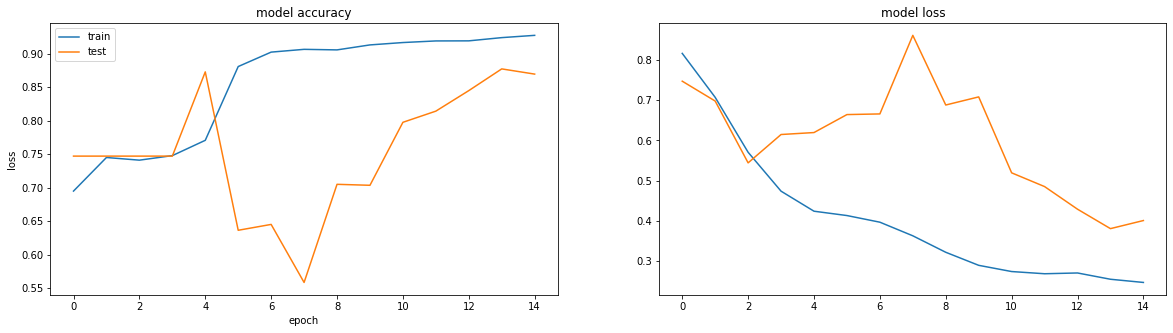

In [ ]:
# Summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
# Summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Load weights and delete redundancy
weight_files = glob.glob(f'{checkpoint_folderpath}/*h5')
print(weight_files[-1])
model.load_weights(weight_files[-1])

#Wiping remaining weight files
for file in weight_files[:-1]:
    os.remove(file)

weights/unet_mini_first_temp/14-0.88.h5


In [ ]:
#Predict
#Ground truth
y_truth = np.ravel(np.argmax(valid_masks, axis = -1))
print(y_truth.shape)
print('True Valid',np.unique(y_truth, return_counts = True))

#Predict
y_pred = []
for index in range(valid_images.shape[0]):
    y_pred.append(model.predict(valid_images[index:index+1, :,:,:]))
y_pred = np.vstack(y_pred)
y_pred = np.ravel(np.argmax(y_pred, axis = -1))
print(y_pred.shape)
print('Pred Valid', np.unique(y_pred, return_counts = True))


(7340032,)
True Valid (array([0, 1]), array([5484949, 1855083]))
(7340032,)
Pred Valid (array([0, 1]), array([5096311, 2243721]))


Classification Report
              precision    recall  f1-score   support

  background       0.95      0.88      0.91   5484949
        lung       0.71      0.86      0.78   1855083

    accuracy                           0.88   7340032
   macro avg       0.83      0.87      0.85   7340032
weighted avg       0.89      0.88      0.88   7340032

Confusion Matrix


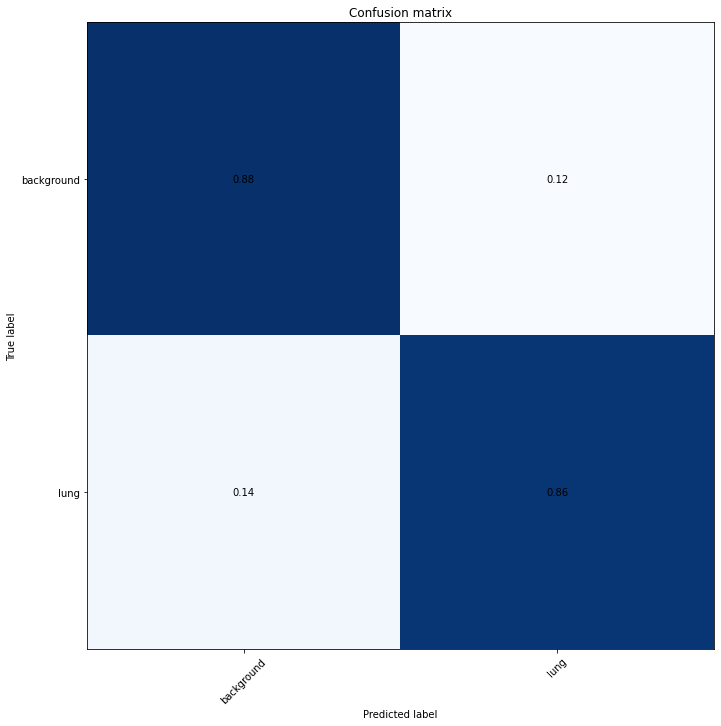

In [ ]:
from evaluate import evaluate
#Evaluation
classes = ['background', 'lung']
evaluate(y_truth, y_pred, classes)